In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
import seaborn as sns
from scipy.stats import norm

In [52]:
ALPHA = 0.05
RANDOM_SEED = 42
sns.set(style='whitegrid', context='poster')
# color codes
healthy_orange = '#EC6602'
healthy_orange_25 = '#FDDDCB'
siemens_petrol = '#009999'
siemens_petrol_50 = '#87D2D2'

In [53]:
df = pd.read_csv('data/movies_data.csv')

df.head()

,Series_Title,Released_Year,Certificate,Runtime,Genre,Subgenre,Subgenre 1,IMDB_Rating,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,The Shawshank Redemption,1994,A,142,Drama,NaN,NaN,9.3,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469.0
1,The Godfather,1972,A,175,Crime,Drama,NaN,9.2,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0
2,The Dark Knight,2008,UA,152,Action,Crime,Drama,9.0,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0
3,The Godfather: Part II,1974,A,202,Crime,Drama,NaN,9.0,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0
4,12 Angry Men,1957,U,96,Crime,Drama,NaN,9.0,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0


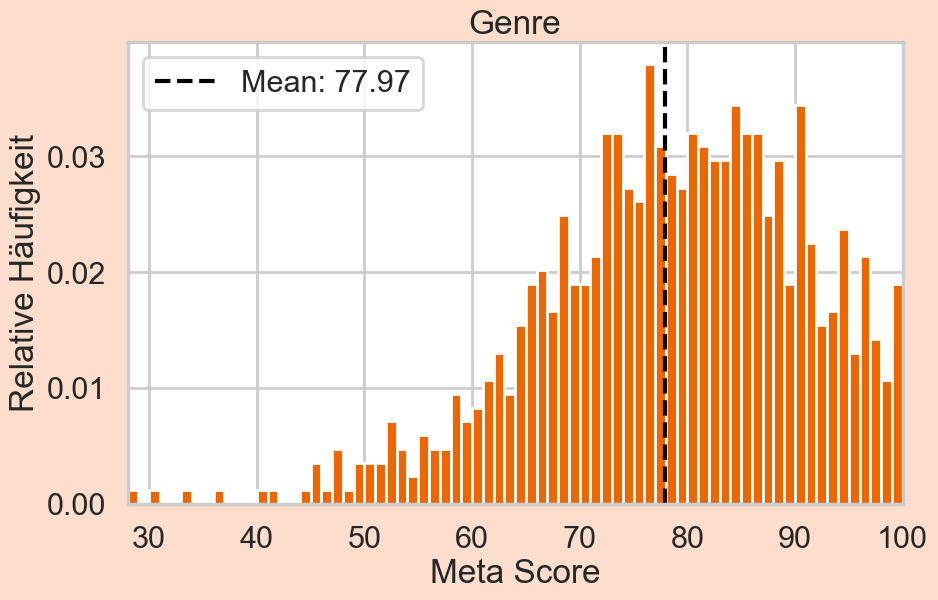

In [54]:
plt.figure(figsize=(10, 6), facecolor=healthy_orange_25)
plt.hist(df.Meta_score, 
         bins=range(int(df.Meta_score.min()), int(df.Meta_score.max()) + 1), 
         color=healthy_orange, 
         density=True)
genre_mean = df.Meta_score.mean()
plt.axvline(x=genre_mean, color='black', label=f'Mean: {genre_mean:.2f}', linestyle='--')
plt.xlabel('Meta Score')
plt.ylabel('Relative Häufigkeit')
plt.title('Genre')
plt.legend()
plt.xlim(int(df.Meta_score.min()), 100)
plt.show()

In [55]:
df_pivoted_meta = df.pivot_table(index='Genre', 
                                 values='Meta_score', 
                                 aggfunc=['mean', 'count', 'median', 'std', 'min', 'max'])

df_pivoted_meta.sort_values(('mean', 'Meta_score'), ascending=False)

,mean,count,median,std,min,max
,Meta_score,Meta_score,Meta_score,Meta_score,Meta_score,Meta_score
Genre,,,,,,
Film-Noir,95.666667,3,96.0,1.527525,94.0,97.0
Animation,81.093333,75,82.0,8.813646,61.0,96.0
Thriller,81.000000,1,81.0,NaN,81.0,81.0
Horror,80.000000,11,87.0,15.362291,46.0,97.0
Drama,79.701245,241,82.0,12.744687,28.0,100.0
Mystery,79.125000,8,77.0,18.604435,52.0,100.0
Family,79.000000,2,79.0,16.970563,67.0,91.0
Comedy,78.720000,125,79.0,11.829160,45.0,99.0


### Einleitung

In der Welt des Kinos spielt die Bewertung von Filmen durch Kritiker eine wichtige Rolle bei dem Erfolg eines Films.

Eine der gewöhnlichen Methoden zur Bewertung ist Meta-Score. Der Meta-Score bietet eine schnelle Übersicht über die allgemeine Meinung zu dem Film.

Meta-Score wird von der Website Metacritic erstellt. Er fast die Kritiken aus verschiedenen Quellen zusammen und berechnet einen Durchschnittswert.

#### Fragestellung:

Wir möchten testen, ob der durchschnittliche Metascore des Genres *Action* signifikant kleiner ist als der des Genres *Drama*.

#### Hypothesenformulierung:

$H_0$: Es gibt keinen signifikanten Unterschied zwischen den durchschnittlichen Metascores der Genres *Action* und *Drama*.
$$\Rightarrow \mu_{Action} \geq \mu_{Drama}$$
$H_1$: Der durchschnittliche Metascore des Genres *Action* ist signifikant kleiner als der des Genres *Drama*.
$$\Rightarrow \mu_{Action} < \mu_{Drama}$$

In [56]:
df_filtered_action = df[df['Genre'] == 'Action']['Meta_score']
df_filtered_drama = df[df['Genre'] == 'Drama']['Meta_score']

In [57]:
df_filtered_action.isna().sum(), df_filtered_drama.isna().sum() 

(np.int64(29), np.int64(48))

In [58]:
df_filtered_action = df_filtered_action[~df_filtered_action.isna()].reset_index(drop=True)
df_filtered_drama = df_filtered_drama[~df_filtered_drama.isna()].reset_index(drop=True)


df_filtered_action.isna().sum(), df_filtered_drama.isna().sum()

(np.int64(0), np.int64(0))

In [59]:
df_filtered_action = df_filtered_action.astype('uint8')
df_filtered_drama = df_filtered_drama.astype('uint8')

df_filtered_action.dtype, df_filtered_drama.dtype

(dtype('uint8'), dtype('uint8'))

In [60]:
df_filtered_action[:10]

0    84
1    94
2    74
3    92
4    87
5    73
6    82
7    90
8    85
9    98
Name: Meta_score, dtype: uint8

In [61]:
df_filtered_drama[:10]

0    80
1    66
2    82
3    83
4    91
5    89
6    88
7    66
8    62
9    80
Name: Meta_score, dtype: uint8

In [62]:
min_drama = df_filtered_drama.min().item()
max_drama = df_filtered_action.max().item()
mean_drama = df_filtered_drama.mean().item()
count_drama = df_filtered_drama.count().item()
std_drama = (df_filtered_drama.std() * (count_drama / (count_drama - 1))**0.5).item()
min_action = df_filtered_action.min().item()
max_action = df_filtered_action.max().item()
mean_action = df_filtered_action.mean().item()
count_action = df_filtered_action.count().item()
std_action = (df_filtered_action.std() * (count_action / (count_action - 1))**0.5).item()

print(f"{min_drama = }\n{max_drama = }\n{mean_drama = :.2f}\n{count_drama = }\n{std_drama = :.2f}")
print(f"{min_action = }\n{max_action = }\n{mean_action = :.2f}\n{count_action = }\n{std_action = :.2f}")

min_drama = 28
max_drama = 98
mean_drama = 79.70
count_drama = 241
std_drama = 12.77
min_action = 33
max_action = 98
mean_action = 73.42
count_action = 143
std_action = 12.46


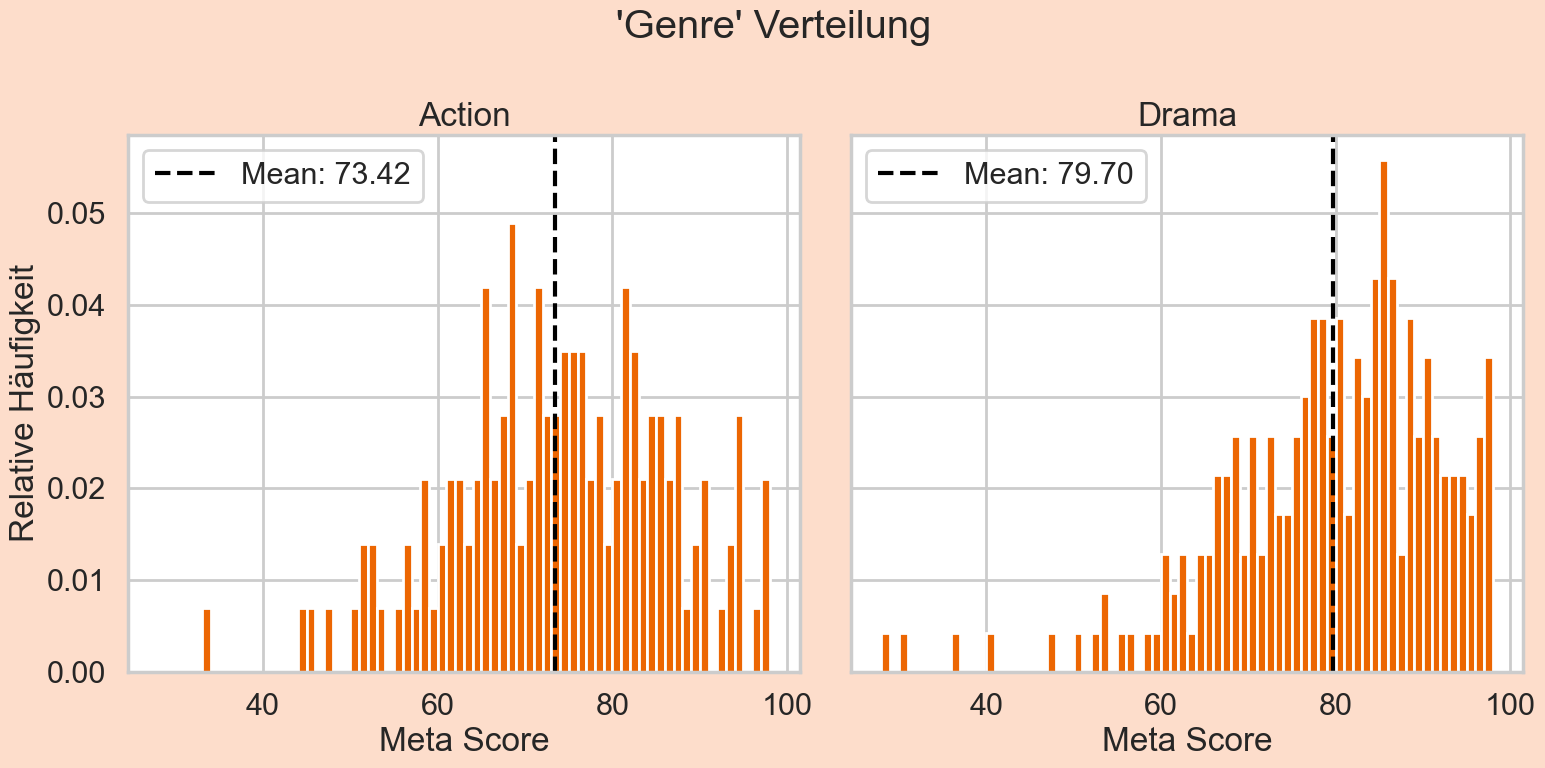

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True, facecolor=healthy_orange_25)

ax[0].hist(df_filtered_action, bins=range(min_action, max_action + 1), color=healthy_orange, density=True)
ax[0].axvline(x=mean_action, color='black', linestyle='--', label=f"Mean: {mean_action:.2f}")
ax[0].set_title('Action')
ax[0].set_xlabel('Meta Score')
ax[0].set_ylabel('Relative Häufigkeit')
ax[0].legend()
ax[1].hist(df_filtered_drama, bins=range(min_drama, max_drama + 1), color=healthy_orange, density=True)
ax[1].axvline(x=mean_drama, color='black', linestyle='--', label=f"Mean: {mean_drama:.2f}")
ax[1].set_title('Drama')
ax[1].set_xlabel('Meta Score')
ax[1].legend()
plt.suptitle("'Genre' Verteilung")
plt.tight_layout()
plt.show()

### Methodik

#### Voraussetzungen:

Da wir zwei unabhängige Stichproben haben und die Mittelwerte vergleichen möchten, können wir folgende Annahmen treffen:

- die Verteilungen der Stichproben sind zumindest annähernd normalverteilt

- die Stichprobengrößen $n$ sind größer als 30, sodass wir laut dem zentralen Grenzwertsatz von einer Normalverteilung der Stichprobenmittelwerte ausgehen können

da wir prüfen, ob der durchschnittliche Metascore des Genres *Action* kleiner ist als der des Genres *Drama* (einseitige Fragestellung), eignet sich hierfür ein **einseitiger t-Test für zwei unabhängige Stichproben für den Mittelwert**.

#### Stichprobengröße:

Mit der geschätzten Standardabweichungen $\hat{s}_{Action}$ und $\hat{s}_{Drama}$ und einem festgelegten kleinsten relevanten Unterschied von $d = 5$ können wir mit der JMP Software die erforderlichen Stichprobengrößen $n_{Action}$ und $n_{Drama}$ berechnen.

Nun können wir zufällig Stichproben ziehen, um die Teststatistik durchzuführen.

#### Kritischer Wert:

Da unsere Stichprobengröße größer als $30$ ist, können wir den berechneten t-Wert direkt mit dem z-Wert vergleichen. Für einen einseitigen Test mit einem Signifikanzniveau von 5 % beträgt der kritische z-Wert $1.65$.

$$\Rightarrow Z_{krit} = 1.65$$ 

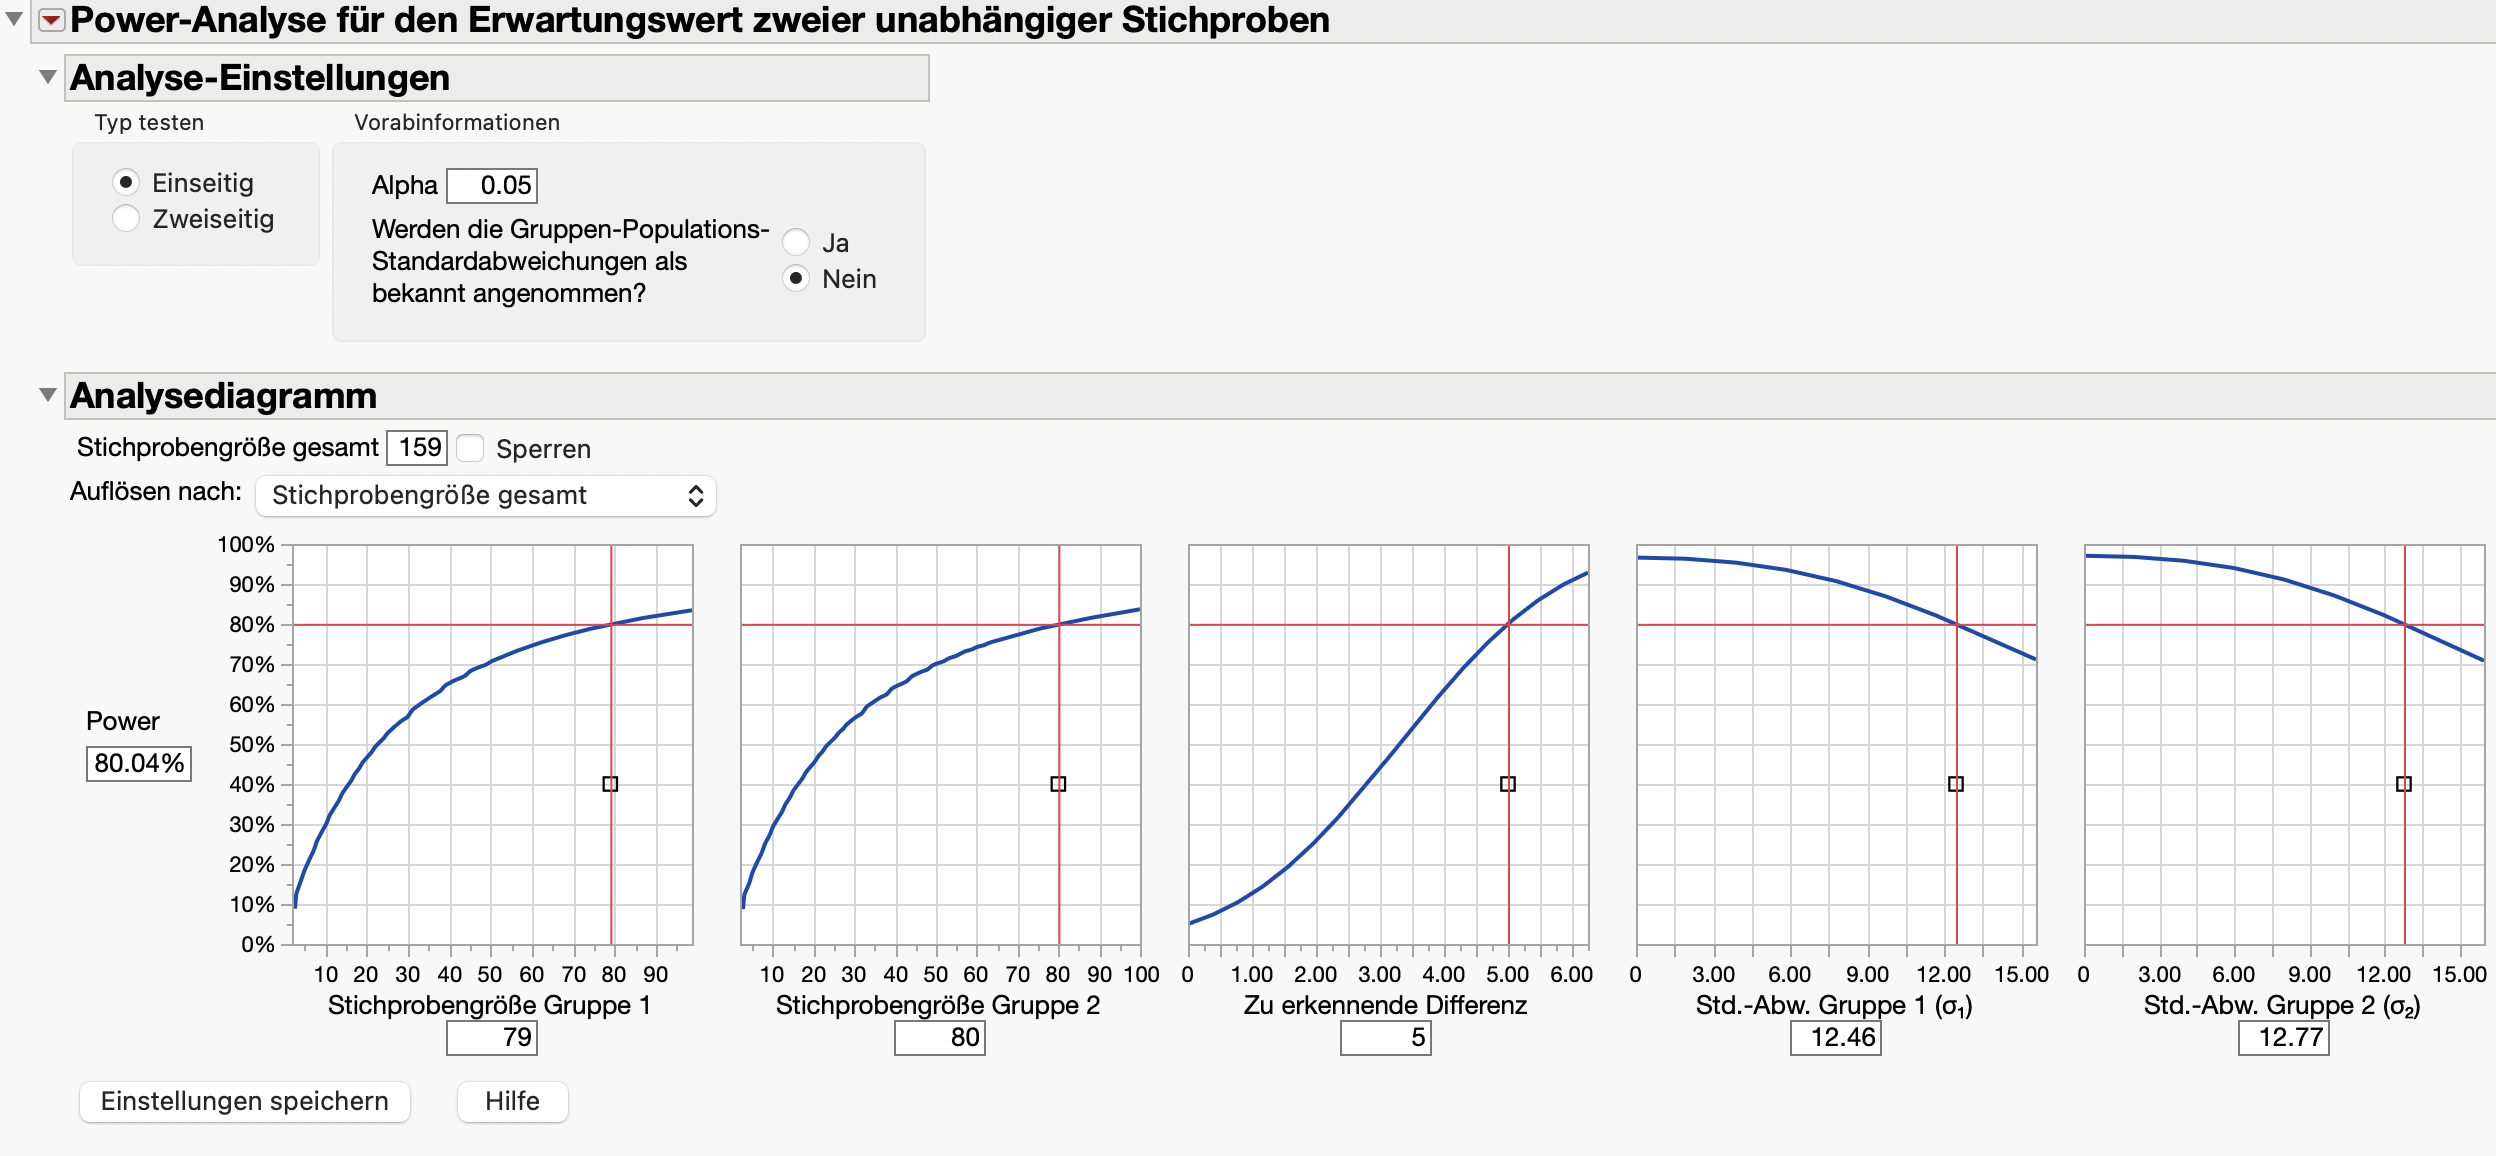

In [64]:
n_action = 79
n_drama = 80
df_action_stichprobe = df_filtered_action.sample(n_action, random_state=RANDOM_SEED)
df_drama_stichprobe = df_filtered_drama.sample(n_drama, random_state=RANDOM_SEED)
std_stichprobe_action = df_action_stichprobe.std() * (n_action / (n_action - 1))**0.5
std_stichprobe_drama = df_drama_stichprobe.std() * (n_drama / (n_drama - 1))**0.5
mean_stichprobe_action = df_action_stichprobe.mean()
mean_stichprobe_drama = df_drama_stichprobe.mean()
std_fehler_drama = std_stichprobe_drama / n_drama**0.5

print(f"Std. 'Action' Stichprobe: {std_stichprobe_action:.2f}\nStd. 'Drama' Stichprobe: {std_stichprobe_drama:.2f}\n\
Mean 'Action' Stichprobe: {mean_stichprobe_action:.2f}\nMean 'Drama' Sitchprobe: {mean_stichprobe_drama:.2f}\n\
Standard Fehler 'Drama' Stichprobe: {std_fehler_drama:.2f}")

Std. 'Action' Stichprobe: 12.42
Std. 'Drama' Stichprobe: 15.29
Mean 'Action' Stichprobe: 72.42
Mean 'Drama' Sitchprobe: 79.20
Standard Fehler 'Drama' Stichprobe: 1.71


In [65]:
t_wert, p_wert = ttest_ind(df_action_stichprobe, df_drama_stichprobe, equal_var=False)

print(f"t-Wert: {t_wert:.2f}\np-Wert: {p_wert*100:.2f}%")

if p_wert < ALPHA:
    print("Signifikantes Ergebnis")
else:
    print("NICHT signifikantes Ergebnis")

t-Wert: -3.09
p-Wert: 0.24%
Signifikantes Ergebnis


### Ergebnis:
Da,
$$\Rightarrow |t| > |Z_{krit}|$$
$\Rightarrow$ $H_0$ wird verworfen, $H_1$ wird angenommen.
$$\Rightarrow \mu_{Action} < \mu_{drama}$$

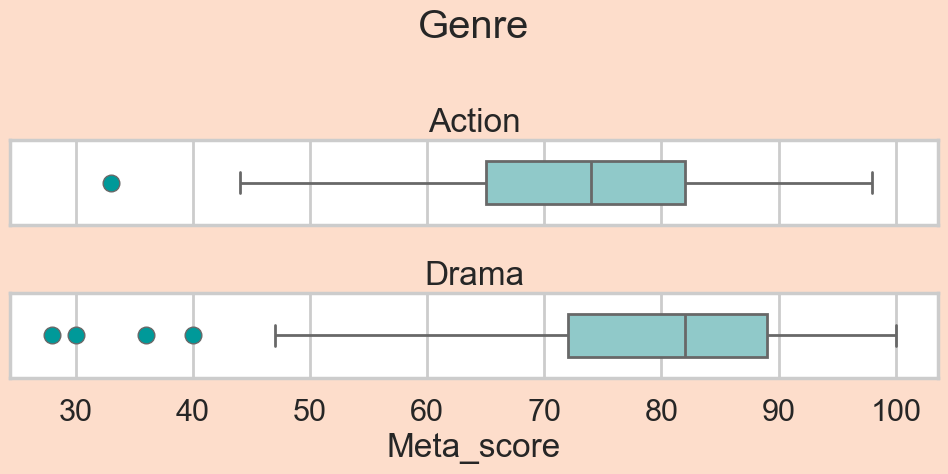

In [66]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True, facecolor=healthy_orange_25)

sns.boxplot(df_filtered_action, 
            ax=ax[0], 
            color=siemens_petrol_50, 
            orient='y', 
            linewidth=2, 
            width=0.5,
            flierprops={'marker': 'o', 'markerfacecolor': siemens_petrol})
ax[0].set_title('Action')

sns.boxplot(df_filtered_drama, 
            ax=ax[1], 
            color=siemens_petrol_50, 
            orient='y', 
            linewidth=2, 
            width=0.5,
            flierprops={'marker': 'o', 'markerfacecolor': siemens_petrol})
ax[1].set_title('Drama')
plt.suptitle('Genre')
plt.tight_layout()
plt.show()

In [67]:
z_krit = norm.ppf(1 - ALPHA)
x_anfang = mean_stichprobe_drama - 5 * std_fehler_drama
x_ende = mean_stichprobe_drama + 5 * std_fehler_drama
untere_grenze = mean_stichprobe_drama - z_krit * std_fehler_drama

print(f"kritscher z-Wert: {z_krit:.2f}\nx-Anfang: {x_anfang:.2f}\
\nx-Ende: {x_ende:.2f}\nuntere Grenze: {untere_grenze:.2f}")

kritscher z-Wert: 1.64
x-Anfang: 70.65
x-Ende: 87.75
untere Grenze: 76.39


In [68]:
x_werte = np.linspace(x_anfang, x_ende, 1000)
y_werte = norm.pdf(x_werte, mean_stichprobe_drama, std_fehler_drama)

print(f"x-Werte: {x_werte[:5]}\ny-Werte: {y_werte[:5]}")

x-Werte: [70.65386799 70.67097736 70.68808673 70.70519611 70.72230548]
y-Werte: [8.69820120e-07 9.14416706e-07 9.61203487e-07 1.01028291e-06
 1.06176196e-06]


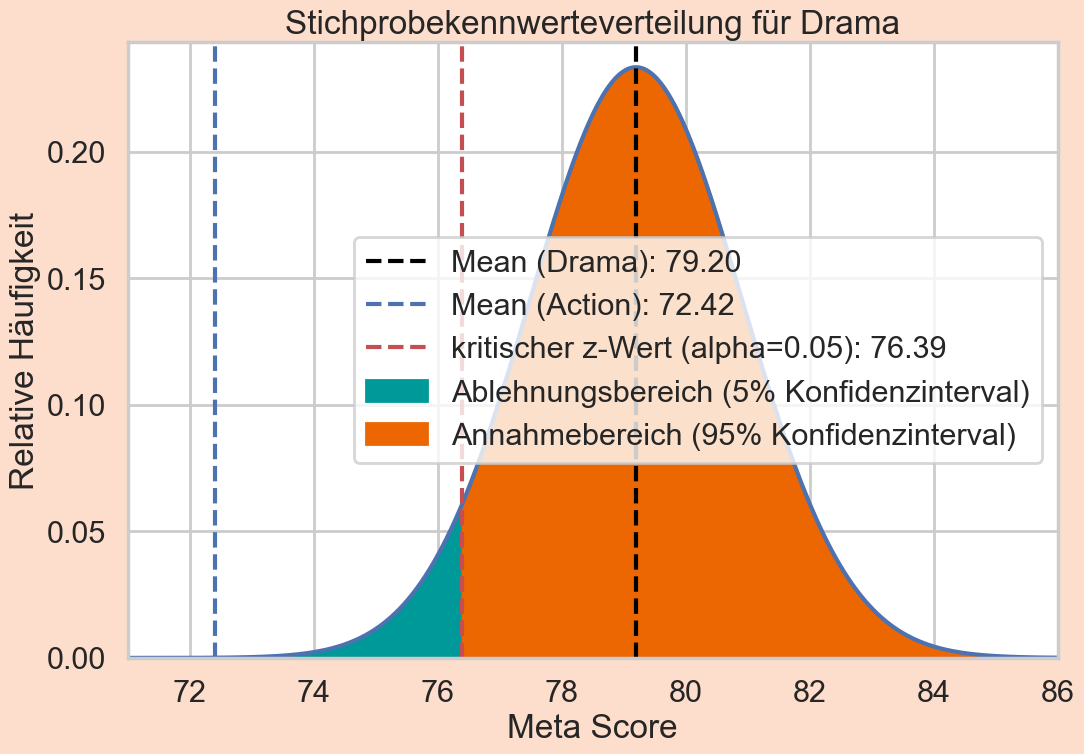

In [69]:
plt.figure(figsize=(12, 8), facecolor=healthy_orange_25)
plt.plot(x_werte, y_werte)
plt.axvline(x=mean_stichprobe_drama, 
            color='black', 
            label=f"Mean (Drama): {mean_stichprobe_drama:.2f}", 
            linestyle='--')
plt.axvline(x=mean_stichprobe_action, 
            label=f"Mean (Action): {mean_stichprobe_action:.2f}", 
            linestyle='--')
plt.axvline(x=untere_grenze, 
            color='r', 
            label=f"kritischer z-Wert (alpha={ALPHA}): {untere_grenze:.2f}", 
            linestyle='--')
plt.fill_between(x_werte, 
                 y_werte, 
                 where=x_werte < untere_grenze, 
                 color=siemens_petrol, 
                 label='Ablehnungsbereich (5% Konfidenzinterval)')
plt.fill_between(x_werte, 
                 y_werte, 
                 where=x_werte > untere_grenze, 
                 color=healthy_orange, 
                 label='Annahmebereich (95% Konfidenzinterval)')
plt.ylim(0, max(y_werte) + 0.01)
plt.title('Stichprobekennwerteverteilung für Drama')
plt.xlabel('Meta Score')
plt.ylabel('Relative Häufigkeit')
plt.xlim(71, 86)
plt.legend()
plt.show()

In [70]:
df_action_stichprobe.describe()

count    79.000000
mean     72.417722
std      12.340893
min      44.000000
25%      65.000000
50%      71.000000
75%      81.000000
max      98.000000
Name: Meta_score, dtype: float64

In [71]:
df_drama_stichprobe.describe()

count     80.000000
mean      79.200000
std       15.191937
min       30.000000
25%       72.000000
50%       80.500000
75%       90.000000
max      100.000000
Name: Meta_score, dtype: float64